In [138]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
# from Bio.Data import CodonTable
# from Bio.Data.CodonTable import NCBICodonTableDNA
# from Bio import SeqIO
from scipy import spatial
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# from mutspec.annotation import (
#     calculate_mutspec, CodonAnnotation, mutations_summary, 
#     translator, rev_comp, lbl2lbl_id, lbl_id2lbl
# )
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
# from mutspec.io import read_genbank_ref
# from mutspec.draw.mut import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

In [185]:
path_to_data = "../data/MutSpecVertebratescytb.csv"
mutspec = pd.read_csv(path_to_data)
print("#species", mutspec.Species.nunique())
print(mutspec.shape)
mutspec.head()

#species 974
(187008, 10)


Species      Mut  Expected  Observed  RawMutSpec  \
0  Abbottina_obtusirostris  T[T>G]T       0.0       0.0         0.0   
1  Abbottina_obtusirostris  G[T>G]T       0.0       0.0         0.0   
2  Abbottina_obtusirostris  C[T>G]T       0.0       0.0         0.0   
3  Abbottina_obtusirostris  A[T>G]T       0.0       0.0         0.0   
4  Abbottina_obtusirostris  T[T>C]T       8.0       0.0         0.0   

   RawMutSpecSum  MutSpec MutBase Context           Class  
0       1.088889      0.0     T>G     TTT  Actinopterygii  
1       1.088889      0.0     T>G     GTT  Actinopterygii  
2       1.088889      0.0     T>G     CTT  Actinopterygii  
3       1.088889      0.0     T>G     ATT  Actinopterygii  
4       1.088889      0.0     T>C     TTT  Actinopterygii

## Drop species with low number of observed mutations!

In [194]:
sp_count = mutspec.groupby("Species").Observed.sum()

MIN_MUT_NUM = 50
mutspec = mutspec[mutspec.Species.isin(sp_count[sp_count > MIN_MUT_NUM].index)]
print("#species", mutspec.Species.nunique())
mutspec.shape[0]

#species 599


115008

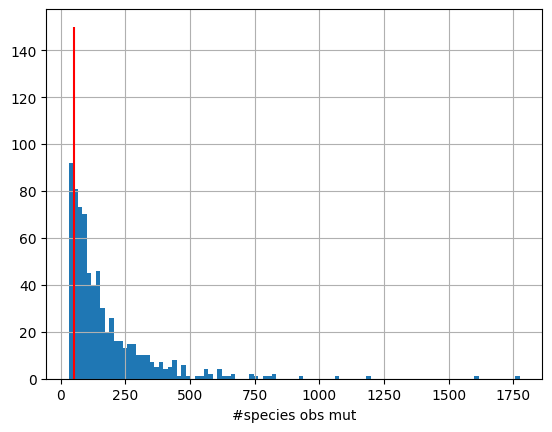

In [196]:
sp_count.hist(bins=100)
plt.xlabel("#species obs mut");
plt.vlines([MIN_MUT_NUM], 0, 150, 'r')

In [197]:
sp2mut = mutspec.pivot(index=["Class", "Species"], columns="Mut", values="MutSpec")
sp2mut = sp2mut[possible_sbs192]
sp2mut.head().round(2)

Mut                                        A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis            0.00      0.0      0.0      0.0   
               Acanthopagrus_schlegelii       0.01      0.0      0.0      0.0   
               Acheilognathus_macropterus     0.00      0.0      0.0      0.0   
               Acheilognathus_rhombeus        0.00      0.0      0.0      0.0   
               Acheilognathus_signifer        0.01      0.0      0.0      0.0   

Mut                                        C[A>C]A  C[A>C]C  C[A>C]G  C[A>C]T  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0     0.00     0.00      0.0   
               Acanthopagrus_schlegelii        0.0     0.00     0.01      0.0   
               Acheilognathus_macropterus      0.0     0.00     0.00      0.0   
               Acheilognathus_rhombeus         0.0     0.00     0.00      0.0   
               Acheilognathus_signifer         0.0     0.01     0.00      0.0   

Mut                                        G[A>C]A  G[A>C]C  ...  C[T>G]G  \
Class          Species                                       ...            
Actinopterygii Abbottina_rivularis            0.00      0.0  ...     0.00   
               Acanthopagrus_schlegelii       0.00      0.0  ...     0.01   
               Acheilognathus_macropterus     0.00      0.0  ...     0.00   
               Acheilognathus_rhombeus        0.00      0.0  ...     0.00   
               Acheilognathus_signifer        0.01      0.0  ...     0.00   

Mut                                        C[T>G]T  G[T>G]A  G[T>G]C  G[T>G]G  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0     0.00      0.0      0.0   
               Acanthopagrus_schlegelii        0.0     0.01      0.0      0.0   
               Acheilognathus_macropterus      0.0     0.00      0.0      0.0   
               Acheilognathus_rhombeus         0.0     0.00      0.0      0.0   
               Acheilognathus_signifer         0.0     0.00      0.0      0.0   

Mut                                        G[T>G]T  T[T>G]A  T[T>G]C  T[T>G]G  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0      0.0      0.0      0.0   
               Acanthopagrus_schlegelii        0.0      0.0      0.0      0.0   
               Acheilognathus_macropterus      0.0      0.0      0.0      0.0   
               Acheilognathus_rhombeus         0.0      0.0      0.0      0.0   
               Acheilognathus_signifer         0.0      0.0      0.0      0.0   

Mut                                        T[T>G]T  
Class          Species                              
Actinopterygii Abbottina_rivularis             0.0  
               Acanthopagrus_schlegelii        0.0  
               Acheilognathus_macropterus      0.0  
               Acheilognathus_rhombeus         0.0  
               Acheilognathus_signifer         0.0  

[5 rows x 192 columns]

## species clustermap

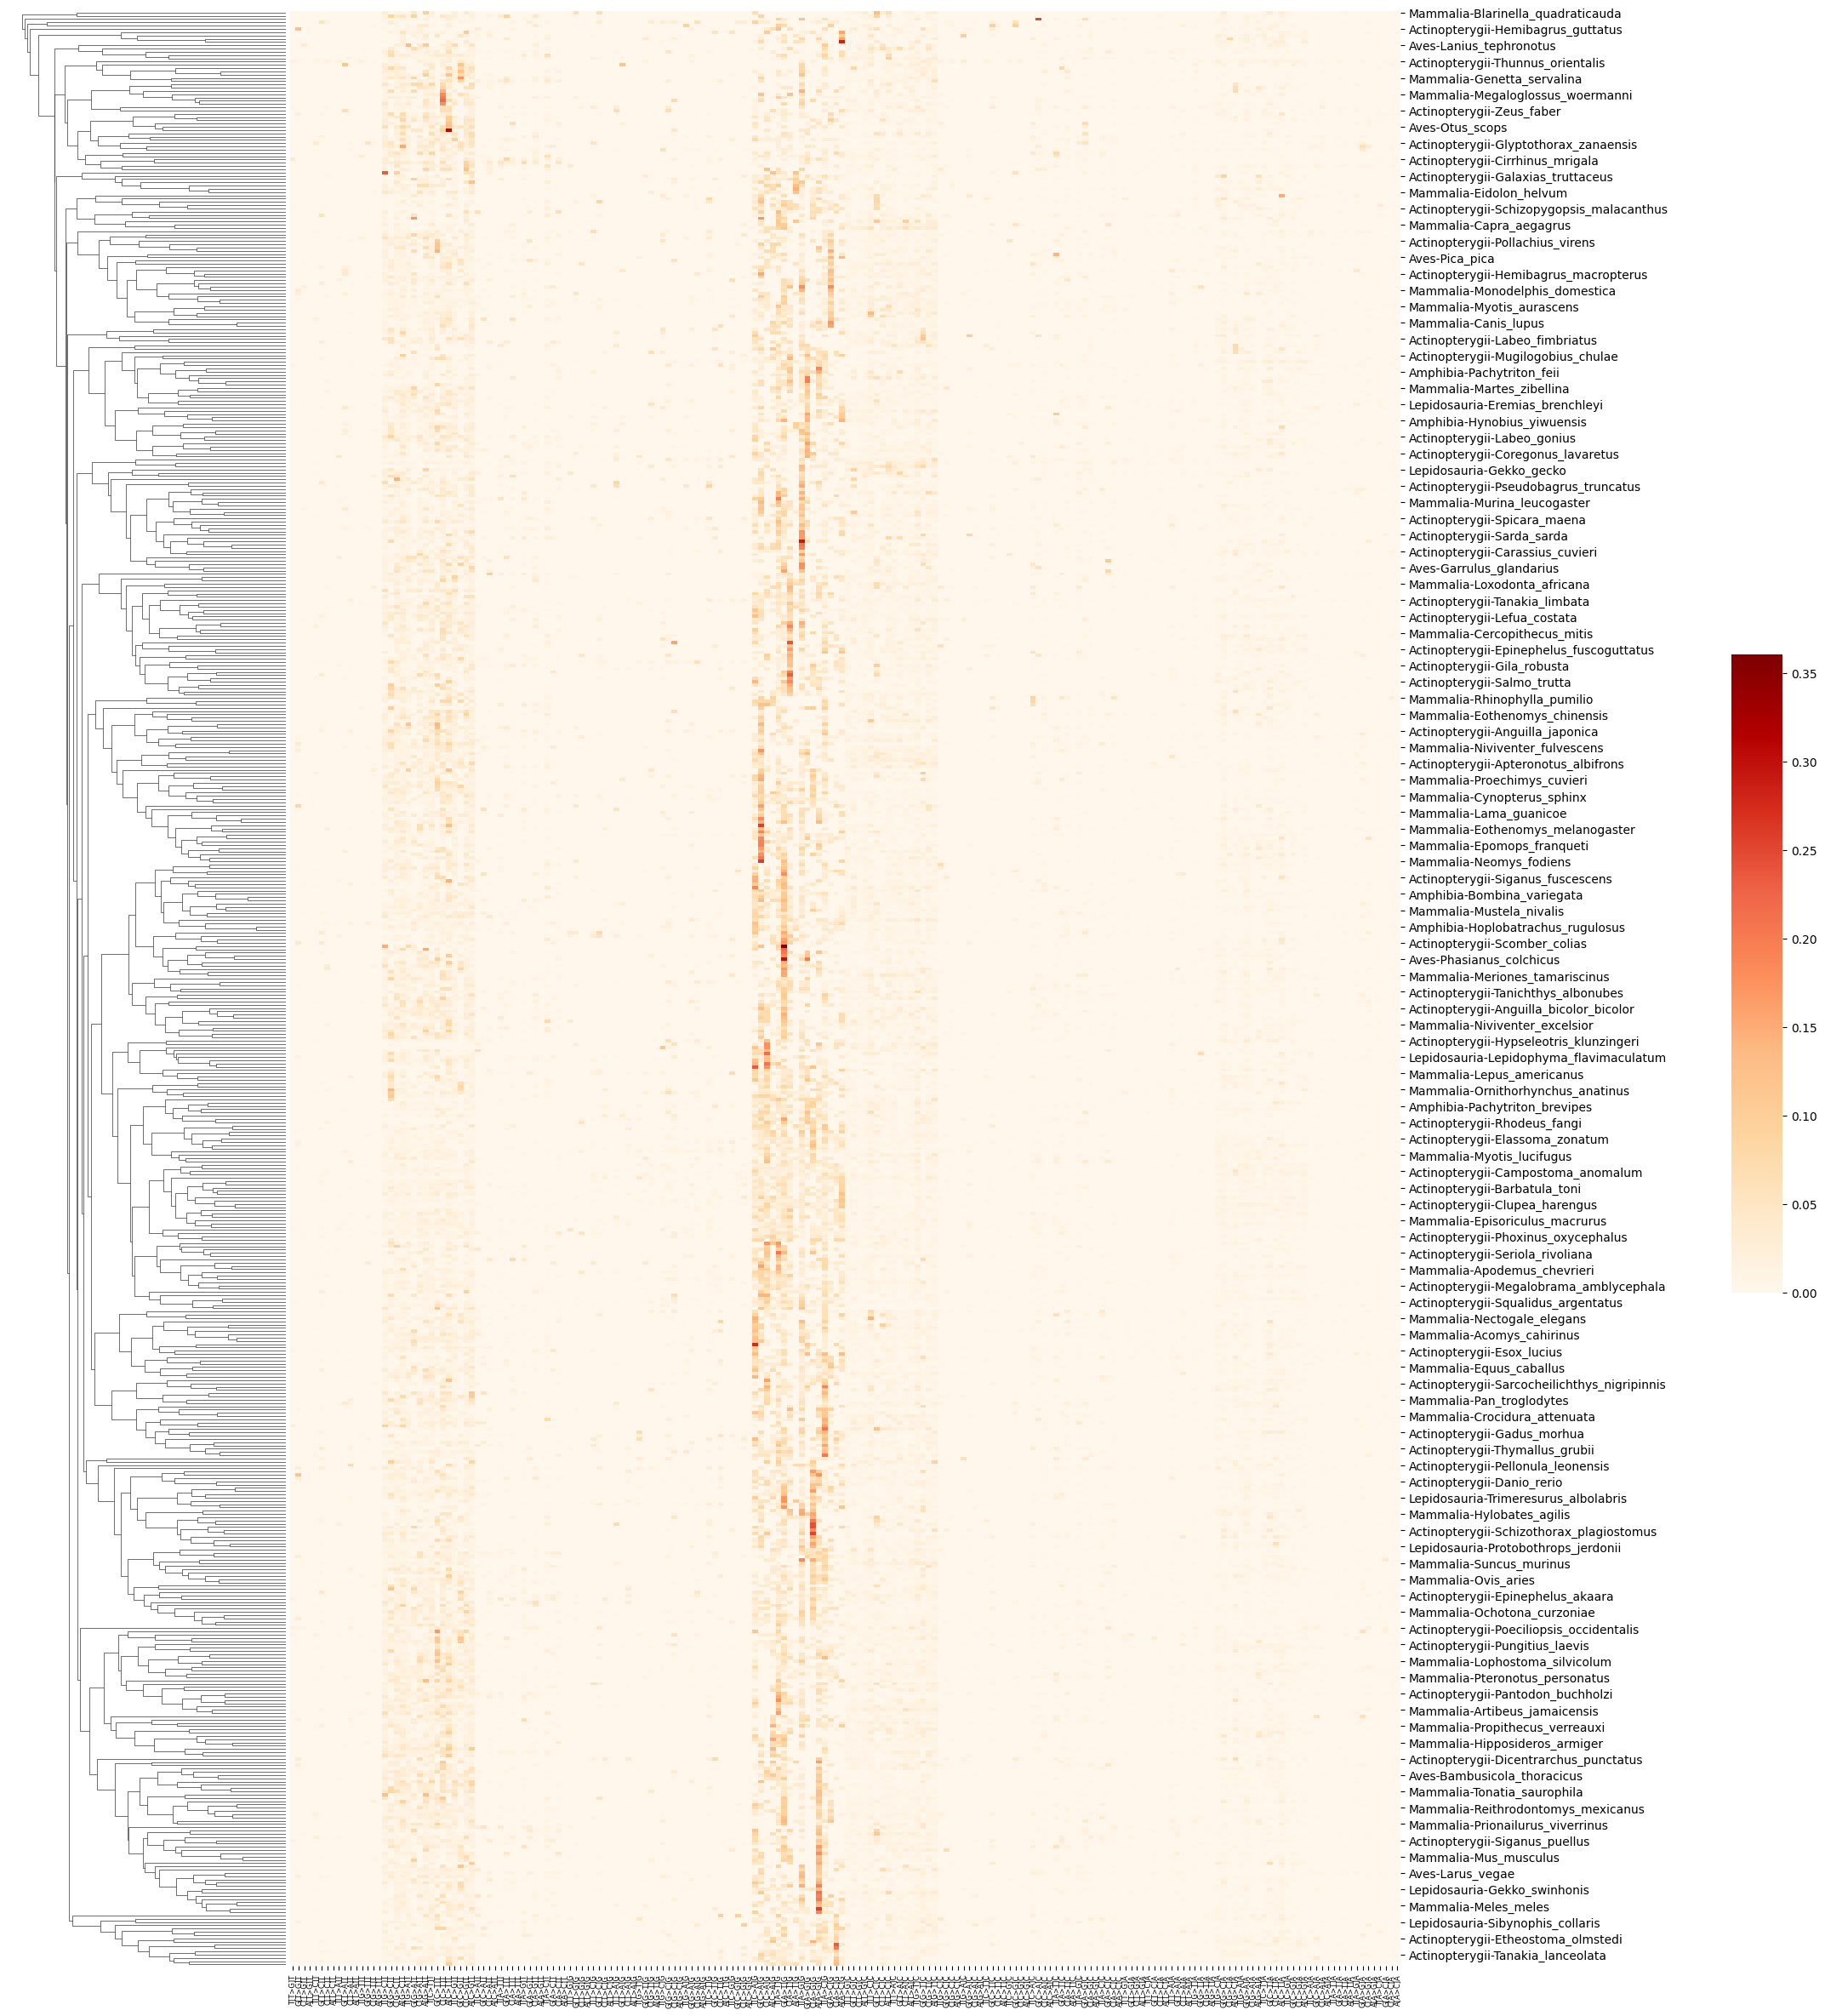

In [64]:
grd = sns.clustermap(
    data=sp2mut, 
    # pivot_kws=dict(index=["Class", "Species"], columns="Mut", values="MutSpec"), 
    col_cluster=False,
    metric=spatial.distance.cosine,
    xticklabels=mutspec.Mut.unique(),
    cmap="OrRd",
    figsize=(20, 30),
    cbar_pos=(1.02, 0.3, 0.03, 0.25),
)
grd.ax_col_dendrogram.remove()
grd.ax_heatmap.set_ylabel("")
grd.ax_heatmap.set_xlabel("")
plt.setp(grd.ax_heatmap.get_xticklabels(), size=6,)
# plt.tight_layout()
# grd.savefig("../pictures/dendromap.pdf")
plt.show()

## Redusing dimensions

### Filter out transversions

In [ ]:
import pymutspec

transitions = [x for x in pymutspec.constants.possible_sbs192 if x[2:5] in {"C>T", "T>C", "A>G", "G>A"}]
len(transitions)

64

In [ ]:
df = df[transitions]

### UMAP & TSNE

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [31]:
pca = PCA()
X_pca = pca.fit_transform(df)
pca.explained_variance_ratio_[:40].sum()

0.9716185192191391

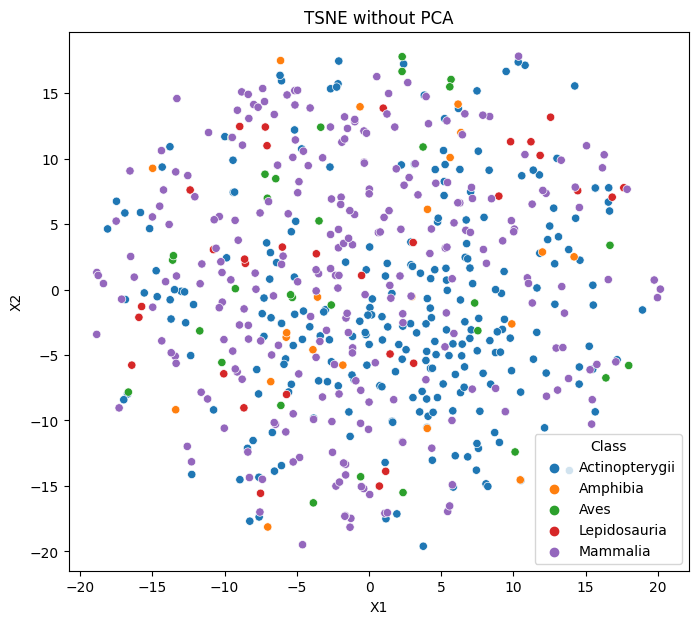

In [32]:
tsne = TSNE(2, n_jobs=12)
X_tsne = tsne.fit_transform(df)

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_tsne)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title("TSNE without PCA")
plt.show()

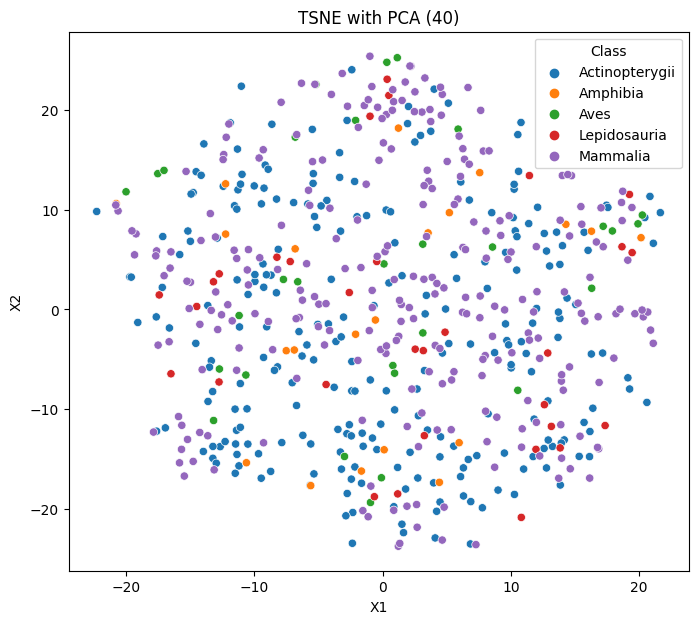

In [34]:
nfea = 40
tsne = TSNE(2, n_jobs=12, metric="cosine")
X_tsne = tsne.fit_transform(X_pca[:, :nfea])

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_tsne)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"TSNE with PCA ({nfea})")
plt.show()

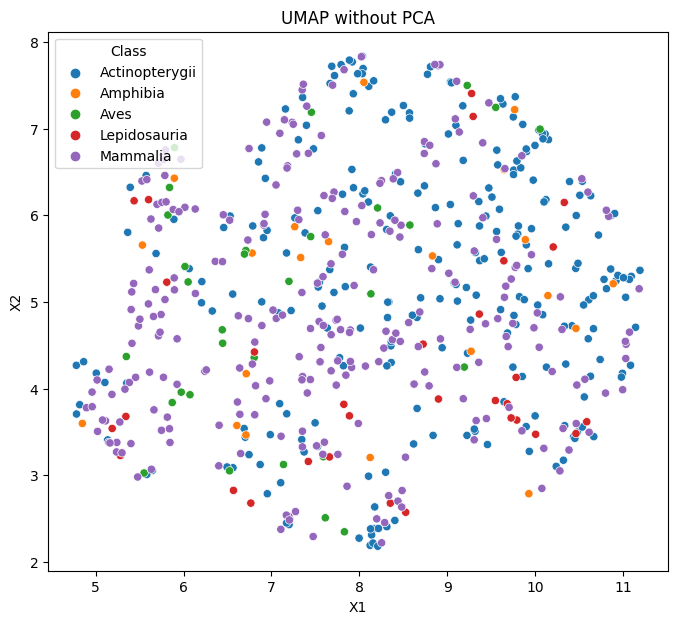

In [35]:
reducer = umap.UMAP(metric="cosine")
X_umap = reducer.fit_transform(df)

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_umap)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"UMAP without PCA")
plt.show()

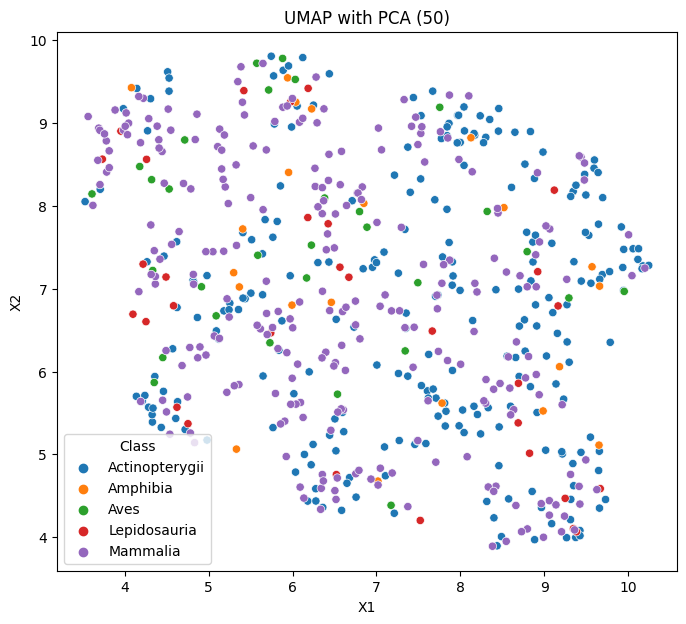

In [37]:
nfea = 50
reducer = umap.UMAP(metric="cosine")
X_umap = reducer.fit_transform(X_pca[:, :nfea])

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_umap)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"UMAP with PCA ({nfea})")
plt.show()

## Pairwise species-specific comparison 192

- [link](https://seaborn.pydata.org/generated/seaborn.clustermap.html)
- [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)
- [link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
- [link](https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot)

In [216]:
data = []
for _cls in ['Aves', 'Lepidosauria', 'Amphibia', 'Actinopterygii', 'Mammalia']:
    print(_cls)
    cls_sp = sp2mut.loc[_cls]
    cls_sp_sim = pd.DataFrame(1 - squareform(pdist(cls_sp, "cosine")), index=cls_sp.index, columns=cls_sp.index)
    dn = dendrogram(linkage(cls_sp_sim), no_plot=True)
    dn["leaves"]
    data.append(cls_sp.iloc[dn["leaves"]].assign(Class=_cls).reset_index().set_index(["Class", "Species"]))

sp2mut_sorted = pd.concat(data)

assert (sp2mut_sorted.sort_index() == sp2mut.sort_index()).all().all()

Aves
Lepidosauria
Amphibia
Actinopterygii
Mammalia


In [217]:
sp2mut_sorted.head()

Mut                       A[A>C]A  A[A>C]C   A[A>C]G  A[A>C]T  C[A>C]A  \
Class Species                                                            
Aves  Gallus_gallus           0.0      0.0  0.000000      0.0      0.0   
      Lanius_tephronotus      0.0      0.0  0.030265      0.0      0.0   
      Anser_cygnoides         0.0      0.0  0.000000      0.0      0.0   
      Regulus_regulus         0.0      0.0  0.000000      0.0      0.0   
      Ithaginis_cruentus      0.0      0.0  0.000000      0.0      0.0   

Mut                       C[A>C]C  C[A>C]G  C[A>C]T   G[A>C]A  G[A>C]C  ...  \
Class Species                                                           ...   
Aves  Gallus_gallus           0.0      0.0      0.0  0.000000      0.0  ...   
      Lanius_tephronotus      0.0      0.0      0.0  0.000000      0.0  ...   
      Anser_cygnoides         0.0      0.0      0.0  0.000000      0.0  ...   
      Regulus_regulus         0.0      0.0      0.0  0.000000      0.0  ...   
      Ithaginis_cruentus      0.0      0.0      0.0  0.010018      0.0  ...   

Mut                        C[T>G]G  C[T>G]T   G[T>G]A  G[T>G]C   G[T>G]G  \
Class Species                                                              
Aves  Gallus_gallus       0.000000      0.0  0.000000      0.0  0.000000   
      Lanius_tephronotus  0.000000      0.0  0.000000      0.0  0.000000   
      Anser_cygnoides     0.000000      0.0  0.000000      0.0  0.000000   
      Regulus_regulus     0.007298      0.0  0.000000      0.0  0.000000   
      Ithaginis_cruentus  0.001670      0.0  0.002004      0.0  0.004007   

Mut                       G[T>G]T   T[T>G]A   T[T>G]C   T[T>G]G  T[T>G]T  
Class Species                                                             
Aves  Gallus_gallus           0.0  0.000000  0.000000  0.000000      0.0  
      Lanius_tephronotus      0.0  0.000000  0.000000  0.000000      0.0  
      Anser_cygnoides         0.0  0.000000  0.000000  0.000000      0.0  
      Regulus_regulus         0.0  0.000000  0.000000  0.000000      0.0  
      Ithaginis_cruentus      0.0  0.003339  0.004007  0.001821      0.0  

[5 rows x 192 columns]

In [218]:
sp_sim = pd.DataFrame(1 - squareform(pdist(sp2mut_sorted, "cosine")), index=sp2mut_sorted.index, columns=sp2mut_sorted.index)
sp_sim.head()

Class                             Aves                                     \
Species                  Gallus_gallus Lanius_tephronotus Anser_cygnoides   
Class Species                                                               
Aves  Gallus_gallus           1.000000           0.084702        0.110283   
      Lanius_tephronotus      0.084702           1.000000        0.367122   
      Anser_cygnoides         0.110283           0.367122        1.000000   
      Regulus_regulus         0.131213           0.361241        0.188561   
      Ithaginis_cruentus      0.496664           0.583216        0.252271   

Class                                                        \
Species                  Regulus_regulus Ithaginis_cruentus   
Class Species                                                 
Aves  Gallus_gallus             0.131213           0.496664   
      Lanius_tephronotus        0.361241           0.583216   
      Anser_cygnoides           0.188561           0.252271   
      Regulus_regulus           1.000000           0.401906   
      Ithaginis_cruentus        0.401906           1.000000   

Class                                                                     \
Species                  Pomatorhinus_ruficollis Henicorhina_leucosticta   
Class Species                                                              
Aves  Gallus_gallus                     0.434964                0.355808   
      Lanius_tephronotus                0.399101                0.600197   
      Anser_cygnoides                   0.215334                0.447416   
      Regulus_regulus                   0.361205                0.471503   
      Ithaginis_cruentus                0.649578                0.596002   

Class                                                         \
Species                  Copsychus_saularis Garrulax_canorus   
Class Species                                                  
Aves  Gallus_gallus                0.227714         0.305465   
      Lanius_tephronotus           0.387738         0.377581   
      Anser_cygnoides              0.458075         0.357833   
      Regulus_regulus              0.388540         0.572007   
      Ithaginis_cruentus           0.462143         0.449044   

Class                                         ...               Mammalia  \
Species                  Ficedula_hyperythra  ... Ailuropoda_melanoleuca   
Class Species                                 ...                          
Aves  Gallus_gallus                 0.259196  ...               0.237289   
      Lanius_tephronotus            0.435577  ...               0.369538   
      Anser_cygnoides               0.364027  ...               0.386721   
      Regulus_regulus               0.406345  ...               0.225727   
      Ithaginis_cruentus            0.534460  ...               0.495276   

Class                                                                         \
Species                  Apodemus_draco Cricetulus_kamensis Ursus_thibetanus   
Class Species                                                                  
Aves  Gallus_gallus            0.406922            0.244275         0.237532   
      Lanius_tephronotus       0.433801            0.470709         0.423092   
      Anser_cygnoides          0.349199            0.386538         0.348501   
      Regulus_regulus          0.276081            0.369700         0.384138   
      Ithaginis_cruentus       0.559295            0.483007         0.452541   

Class                                                                 \
Species                  Ctenomys_sociabilis Leptonychotes_weddellii   
Class Species                                                          
Aves  Gallus_gallus                 0.131694                0.179709   
      Lanius_tephronotus            0.165948                0.204920   
      Anser_cygnoides               0.272392                0.326094   
      Regulus_regulus               0.477980                0.522770   
  

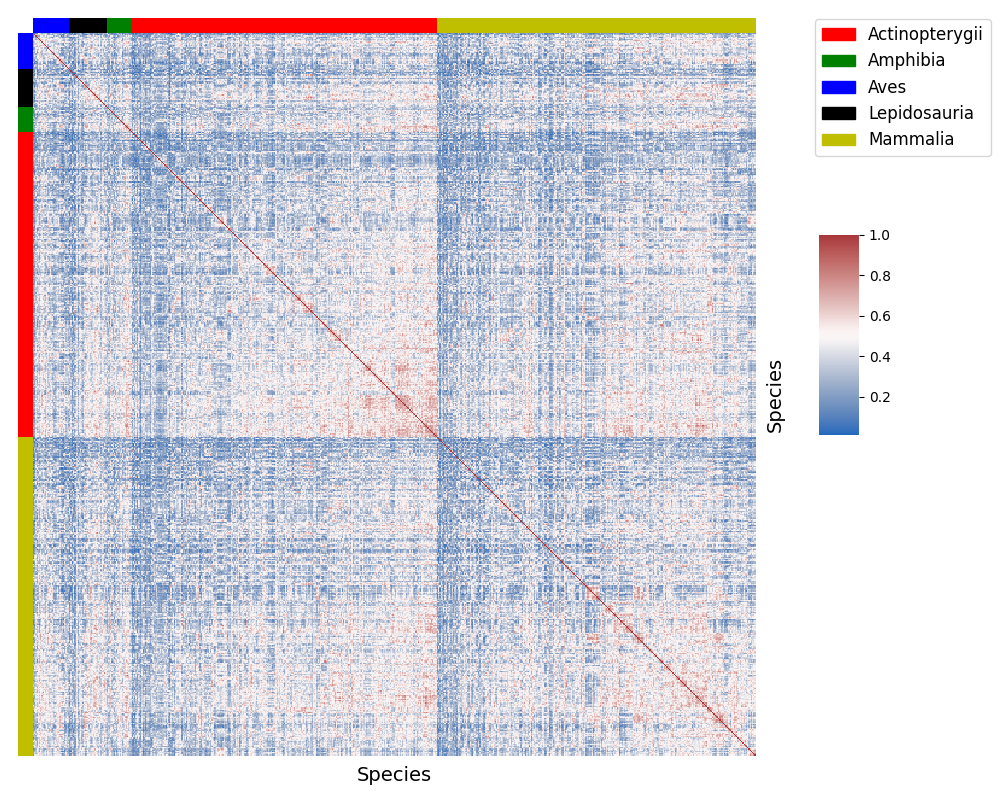

In [219]:
cls_colors = "rgbky"

g = sns.clustermap(
    sp_sim, 
    cmap="vlag",
    metric="cosine",
    row_cluster=False,
    col_cluster=False,
    row_colors=sp_sim.index.get_level_values(0).map(dict(zip(sp_sim.index.levels[0], cls_colors))),
    col_colors=sp_sim.index.get_level_values(0).map(dict(zip(sp_sim.index.levels[0], cls_colors))),
    cbar_pos=(1.03, 0.45, 0.05, 0.25),
    xticklabels=False,
    yticklabels=False,
    figsize=(8, 8),
    dendrogram_ratio=0.01,
    colors_ratio=0.02,
)

g.ax_heatmap.set_xlabel("Species", fontsize=14)
g.ax_heatmap.set_ylabel("Species", fontsize=14)

patches = [mpatches.Patch(color=clr, label=c) for clr, c in zip(cls_colors, sp_sim.index.levels[0])]

plt.legend(handles=patches, fontsize=12, bbox_to_anchor=(4.5, 2.12))


plt.savefig("../pictures/species_pairwise_similarity.png", bbox_inches="tight")
plt.show()

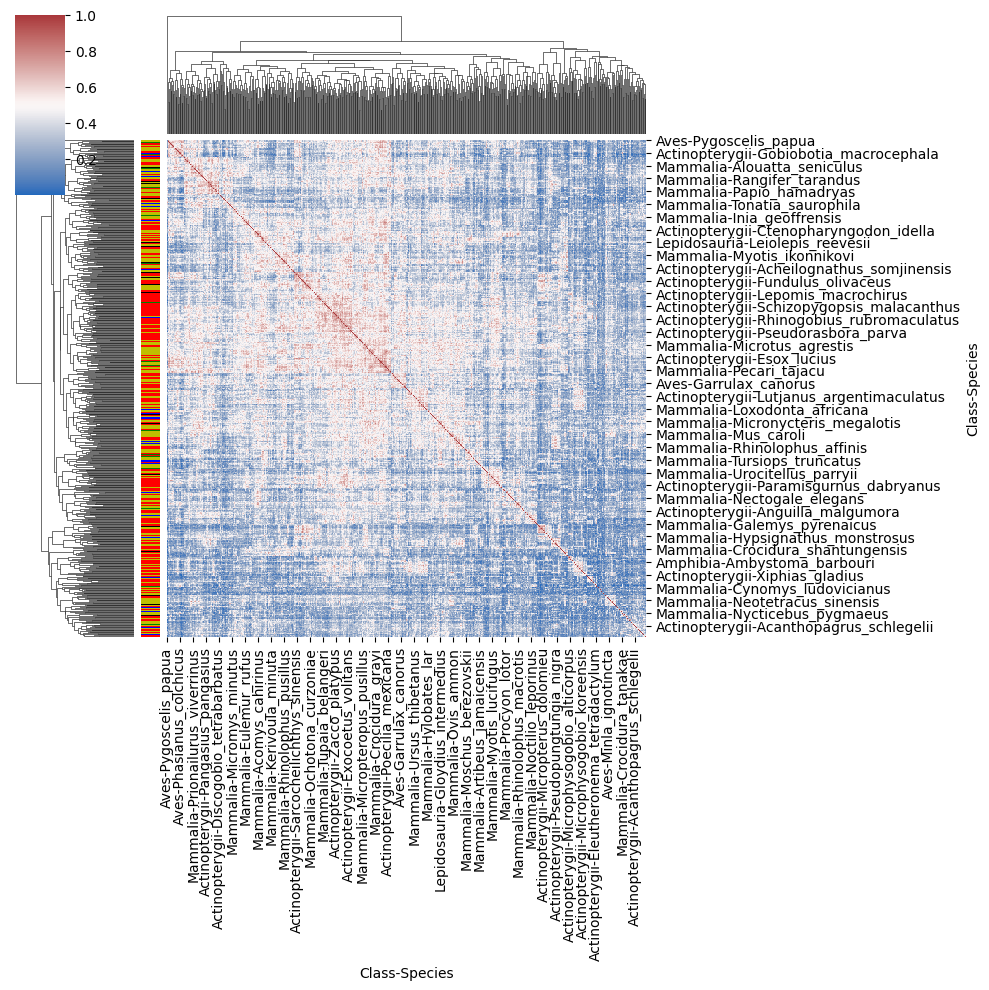

In [8]:
sns.clustermap(sp_sim, cmap="vlag", row_colors=sp_sim.index.get_level_values(0).map(dict(zip(sp_sim.index.levels[0], "rgbky"))))

Cannot see class similarities

In [196]:
data = []
for cl1 in sp_sim.index.levels[0]:
    for cl2 in sp_sim.index.levels[0]:
        if cl1 == cl2:
            cur_sims = 1 - pdist(sp2mut.loc[cl1], "cosine")
        else:
            cur_sims = 1 - cdist(sp2mut.loc[cl1], sp2mut.loc[cl2], "cosine").flatten()
        data.append([cl1, cl2, cur_sims])

cls_sims = pd.DataFrame(data, columns=["cls1", "cls2", "pp_sims"])

In [198]:
cls_sims.head()

cls1            cls2  \
0  Actinopterygii  Actinopterygii   
1  Actinopterygii        Amphibia   
2  Actinopterygii            Aves   
3  Actinopterygii    Lepidosauria   
4  Actinopterygii        Mammalia   

                                             pp_sims  
0  [0.5105016710500526, 0.20497179235784468, 0.60...  
1  [0.20888842703274824, 0.20999189818591324, 0.3...  
2  [0.48238511560987185, 0.5691001007851193, 0.51...  
3  [0.1782423571624796, 0.2835929822453318, 0.405...  
4  [0.4386866522532392, 0.3430308874656821, 0.558...

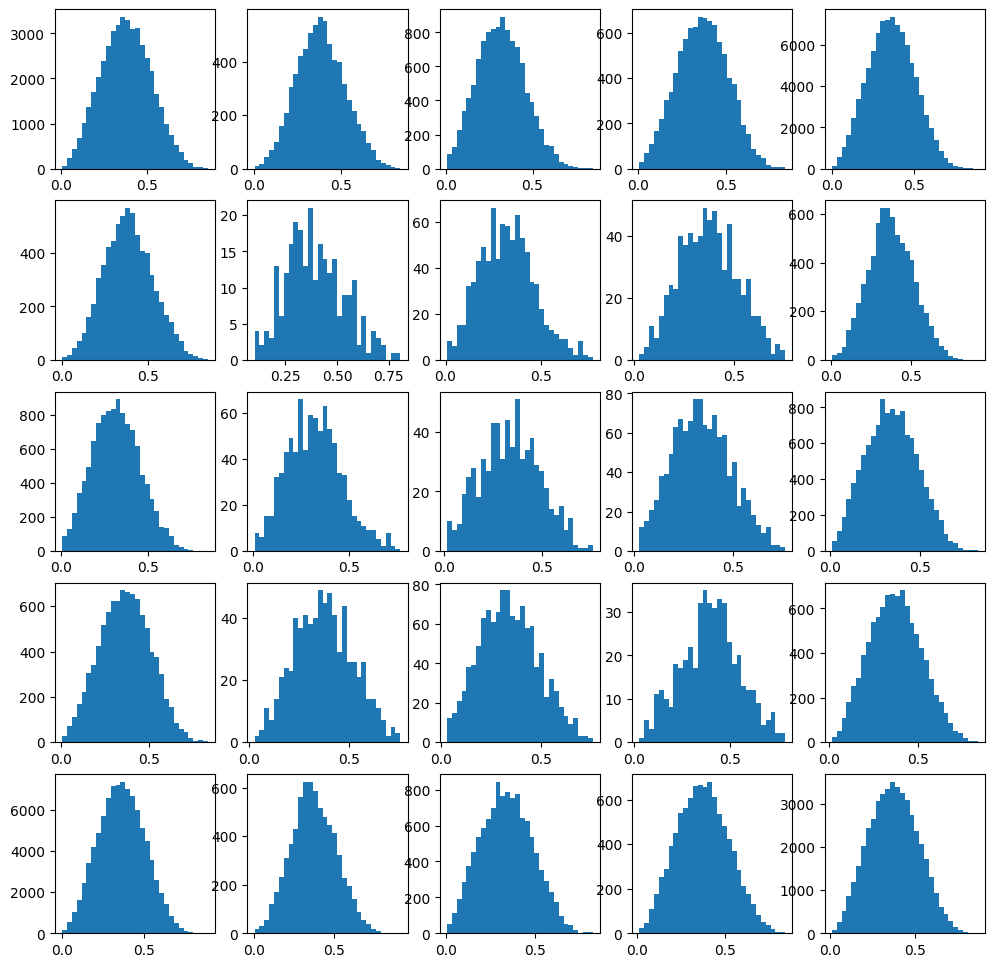

In [199]:
plt.figure(figsize=(12, 12))
for i, cl1 in enumerate(sp_sim.index.levels[0], 1):
    for j, cl2 in enumerate(sp_sim.index.levels[0], 1):
        plt.subplot(5, 5, (i-1)*5+j)
        plt.hist(cls_sims[(cls_sims.cls1 == cl1) & (cls_sims.cls2 == cl2)].pp_sims.item(), bins=30)

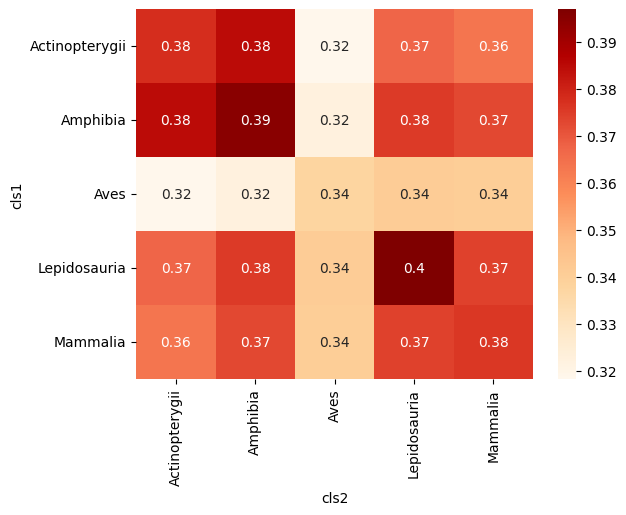

In [201]:
sns.heatmap(cls_sims.set_index(["cls1", "cls2"]).pp_sims.apply(np.mean).unstack(), annot=True, cmap="OrRd");

## Pairwise species-specific comparison 12

In [11]:
s192to12 = dict()
for sbs192 in possible_sbs192:
    s192to12[sbs192] = sbs192[2:5]

In [12]:
for sbs192 in possible_sbs192:
    sbs12 = sbs192[2:5]
    if sbs12 in sp2mut.columns:
        sp2mut[sbs12] += sp2mut[sbs192]
    else:
        sp2mut[sbs12] = sp2mut[sbs192]

In [19]:
sp_sim12 = pd.DataFrame(1 - squareform(pdist(sp2mut[possible_sbs12], "cosine")), index=sp2mut.index, columns=sp2mut.index)

In [20]:
sp_sim12.index.get_level_values(0).map(dict(zip(sp_sim12.index.levels[0], "rgbkp")))

Index(['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       ...
       'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'],
      dtype='object', name='Class', length=700)

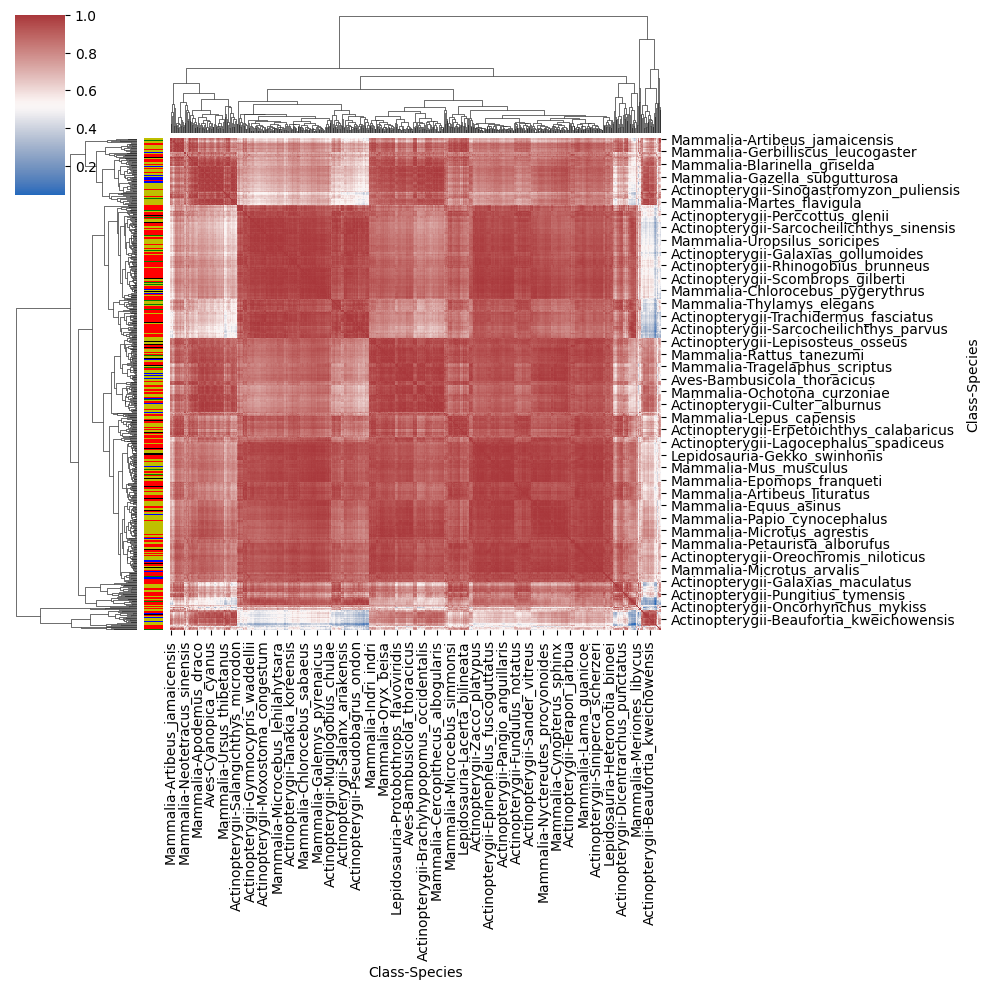

In [21]:
sns.clustermap(sp_sim12, cmap="vlag", row_colors=sp_sim12.index.get_level_values(0).map(dict(zip(sp_sim12.index.levels[0], "rgbky"))))

Cannot see class similarities

In [23]:
data = []
for cl1 in sp_sim12.index.levels[0]:
    for cl2 in sp_sim12.index.levels[0]:
        if cl1 == cl2:
            cur_sims = 1 - pdist(sp2mut.loc[cl1], "cosine")
        else:
            cur_sims = 1 - cdist(sp2mut.loc[cl1], sp2mut.loc[cl2], "cosine").flatten()
        data.append([cl1, cl2, cur_sims])

cls_sims12 = pd.DataFrame(data, columns=["cls1", "cls2", "pp_sims"])

In [24]:
cls_sims12.head()

cls1            cls2  \
0  Actinopterygii  Actinopterygii   
1  Actinopterygii        Amphibia   
2  Actinopterygii            Aves   
3  Actinopterygii    Lepidosauria   
4  Actinopterygii        Mammalia   

                                             pp_sims  
0  [0.7593471070339853, 0.34420351366010715, 0.87...  
1  [0.4600262445213459, 0.7564878025847813, 0.863...  
2  [0.7122852403178261, 0.7837096496600429, 0.784...  
3  [0.7235132026444847, 0.5499483117293164, 0.825...  
4  [0.7292462822718876, 0.6422128375651541, 0.912...

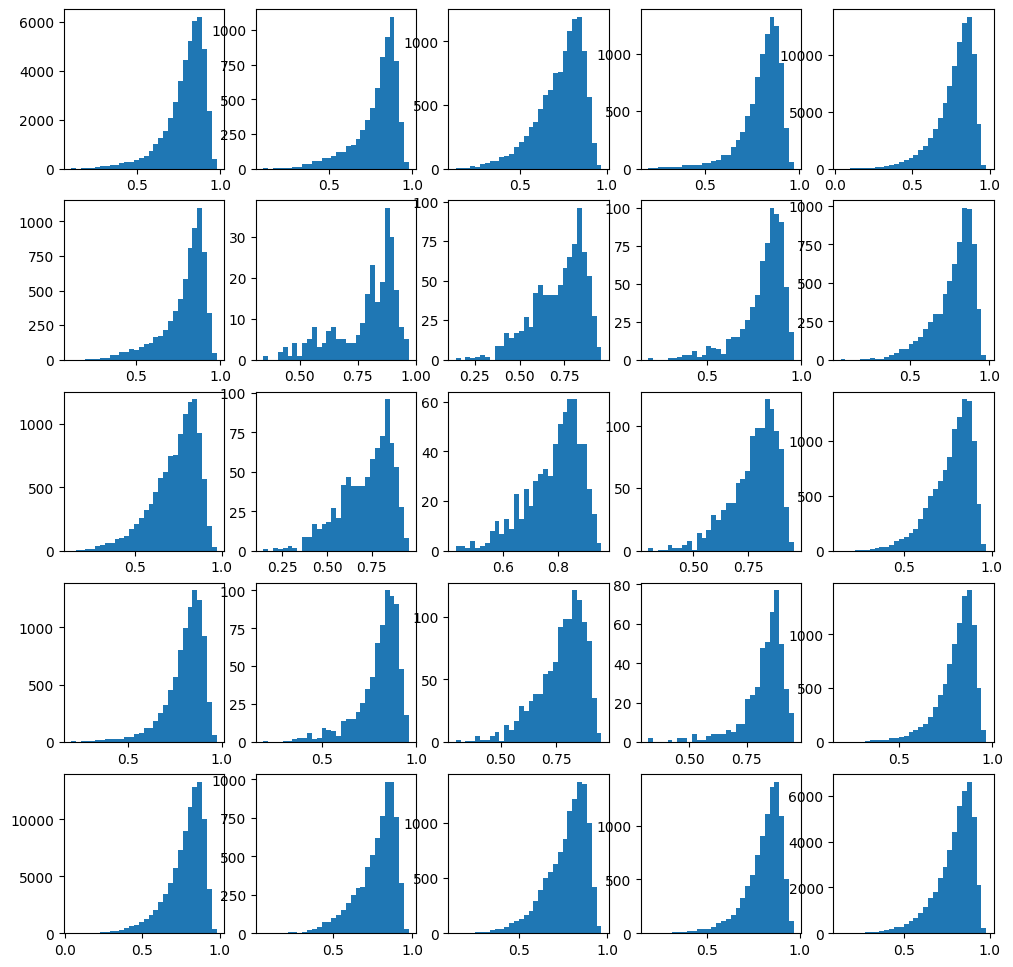

In [25]:
plt.figure(figsize=(12, 12))
for i, cl1 in enumerate(sp_sim12.index.levels[0], 1):
    for j, cl2 in enumerate(sp_sim12.index.levels[0], 1):
        plt.subplot(5, 5, (i-1)*5+j)
        plt.hist(cls_sims12[(cls_sims12.cls1 == cl1) & (cls_sims12.cls2 == cl2)].pp_sims.item(), bins=30)

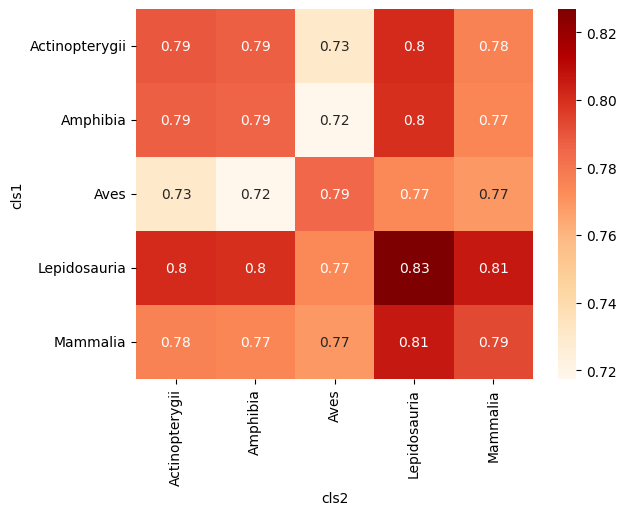

In [26]:
sns.heatmap(cls_sims12.set_index(["cls1", "cls2"]).pp_sims.apply(np.mean).unstack(), annot=True, cmap="OrRd");